<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Examples.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>

# Examples: K-means clustering
© ExploreAI Academy

In the train, we will explore the application of K-means clustering, an unsupervised learning technique, to group data points based on similarities in their features. We'll cover theory, implementation using sklearn, and methods for determining the optimal number of clusters, providing insights into underlying patterns within datasets.

## Learning Objectives
By the end of this train, you should be able to:
- Implement the K-means clustering algorithm
- Implement a K-means clustering model in sklearn
- Choose the optimal number of clusters.

## Introduction 

**Unsupervised learning** is an area of statistical learning that we use to infer trends to group cases based on similar attributes, naturally occurring trends, patterns, or relationships from unlabeled data. These models are often referred to as self-organising maps. A variety of methods are used as a strategy for dividing data into groups to carry out unsupervised learning, one of which is known as **clustering**. Clustering methods use data features to group observations into either distinct or overlapping sets.

Let's learn more about how clustering works!

## Clustering
Clustering is the process of grouping similar data points together, such that data points in the same groups are more similar to other data points in that group than those in other groups. 

The aim is to divide groups with similar characteristics and assign them to clusters. This will give us insights into the underlying patterns of the different groups/clusters. In this course, we will explore three types of clustering:

* **Hard Clustering**
* **Hierarchical Clustering**
* **Soft/Fuzzy Clustering**

Explanations are given in the image below.

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-clustering-types.png?raw=true" alt="Types of Clustering" style="width: 80%;"/>


## The K-means clustering algorithm
K-means is an example of what is known as a **hard clustering** method, which means that the clusters, or groups that result, are distinct and non-overlapping. In other words, each observation will ultimately belong to only one cluster, although it may be passed around between clusters during the iterative training of the clustering model.

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-kmeans-clusters.png?raw=true" alt="Types of Clustering" style="width: 70%">

The main objective in K-means is to partition a dataset into K clusters. This is achieved by randomly initialising K cluster centroids (points to be used as the cluster centres), assigning each data point to the nearest centroid (according to some **distance measure**), and then updating the cluster centroids as well as data point membership at each iteration until the centroids stop changing.

One drawback of the K-means algorithm (and many other clustering algorithms) is that the analyst needs to specify the number of clusters, K. This is a difficult task because this number is seldom obvious for most real-world datasets. However, we do have methods available which we can use to determine the optimal number of clusters. We will cover some of these later on, but for now, let's take a look at the K-means algorithm, which, although it comes in many flavours, generally works as follows:

1. Pick the number of clusters K and randomly assign each observation a cluster number from 1 to K.
2. Repeat the following until cluster assignments stop changing:  
    a. For each of the K clusters, compute the cluster centroid. The $k^{th}$ cluster centroid is the mean of the observations in the $k^{th}$ cluster.  
    b. Assign each observation to the cluster whose centroid is closest (where closest is defined using a chosen distance metric such as **Euclidean distance**).
    
The sequence of images below illustrates the K-means algorithm as it iterates over a data set (these correspond to the algorithm above).

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/clustering_algorithm.png?raw=true" alt="Types of Clustering" style="width: 70%">


## K-means in sklearn

Let's cement this theory by implementing, or fitting, a K-means model to some data.  

### Setting up the data
Before we dive in, let's load in our libraries and go ahead and create some toy data to work with. 

In [1]:
# data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

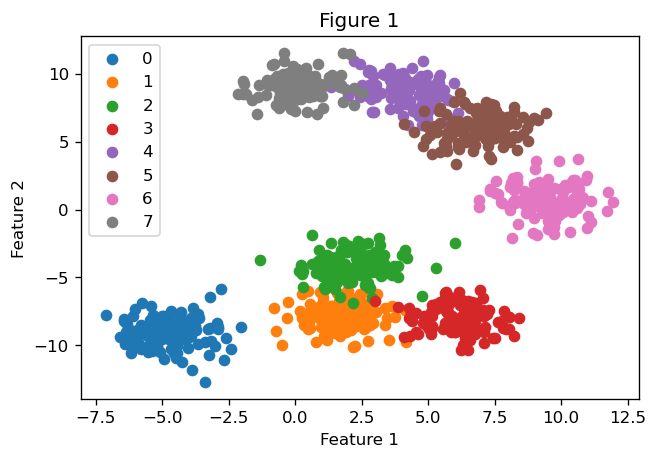

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate 8 blobs in 2D space
n_features = 2
centers = 8

X, y = make_blobs(n_samples=1000, centers=centers, n_features=n_features, random_state=68)

# Create a DataFrame
data = np.concatenate([X, y.reshape(-1, 1)], axis=1)
df = pd.DataFrame(data, columns=[*[f'feature_{i}' for i in range(n_features)], 'y'])
df['y'] = df['y'].astype(int)

# Plot the data
plt.figure(dpi=120)
for center in range(centers):
    x1 = df[df['y'] == center]['feature_0']
    x2 = df[df['y'] == center]['feature_1']
    plt.scatter(x1, x2, label=str(center))

plt.legend()
plt.title("Figure 1")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Great! We've successfully created a dataset consisting of two features and a few distinct clusters (indicated by different colours in the plot shown above). These colours act as a sort of label, i.e., for any pair of features $X$, we know what the corresponding label $y$ (the colour or cluster number) is. As such, this means that we have a labelled dataset.

In [4]:
# what does the data look like?
df.head()

,feature_0,feature_1,y
0,-5.295432,-9.053238,0
1,2.058577,-5.251177,2
2,3.687847,9.551016,4
3,-3.914157,-8.430547,0
4,2.510445,9.198077,4


However, in unsupervised learning, we do not have access to these labels. As such, let's pretend we don't know the number of clusters (or their locations) and pretend that we just came across the following dataset.

In [5]:
# same data with the y column dropped
df_no_labels = df.drop('y',axis=1)

Text(0, 0.5, 'Feature 2')

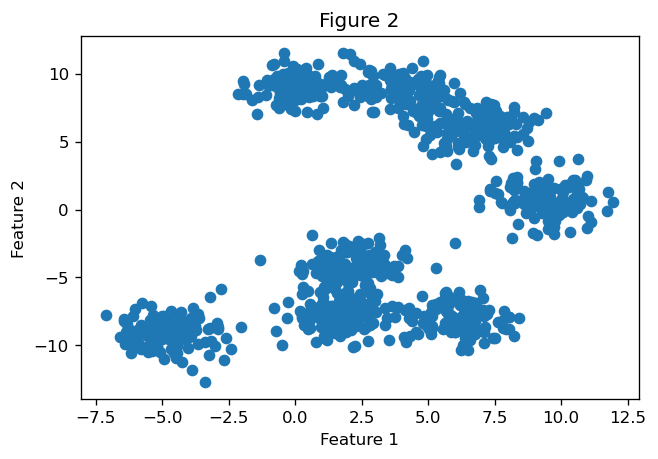

In [6]:
plt.figure(dpi=120)
x1 = df_no_labels['feature_0']
x2 = df_no_labels['feature_1']
plt.scatter(x1, x2)
plt.title("Figure 2")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

This leaves us with two problems to solve:

1. We don't know which pair of features, $X$, belong to which cluster.

2. We don't know how many clusters, $K$, there are in the dataset. 


We usually address the first problem by building a clustering machine learning model, and we address the second problem by making an educated guess of how many clusters there are. As you will notice with the K-means algorithm, many clustering algorithms require that we first select the number of clusters 𝐾 before training the machine learning model.

### Preprocessing the data

Since clustering algorithms rely on computing some form of distance metric, it is good practice to scale the data. If we don't do this, then we risk having features that contribute way more than others when deciding which cluster a given data point belongs to. For example, let's suppose we had a dataset with two features: `age` (ranging from `18` to `60`) and `income` (ranging from `10000` to `45000`). If we attempt to cluster without rescaling or normalising, then the `income` feature will always dominate the distance calculation to the extent that our results would be the same as if we didn't have the `age` feature in our dataset. 

In [7]:
# create scaler object
scaler = StandardScaler()

# scale the data
X_scaled = scaler.fit_transform(df_no_labels)

### Deciding on K

With clustering, we can't be too sure how many clusters we will get, and what information they will be clustered on! Looking at Figure 2 above, it seems that we have 4 or 5 distinct clusters. Let's pick $K=4$ for now.

In [8]:
K = 4

### Fitting the K-means model

Finally, apply Sklearn's `KMeans` model to our data.

In [9]:
# Import KMeans model
from sklearn.cluster import KMeans
# Import time to measure algorithm runtime 
from time import time

In [10]:
km = KMeans(n_clusters=K, random_state=42)
km.fit(X_scaled)

KMeans(n_clusters=4, random_state=42)

Notice that we have only picked two hyperparameters in this case: `n_clusters` (K) and `random_state` (the algorithm has random elements, and this helps ensure that we can reproduce our results). However, there are other useful hyperparameters such as `max_iter`, `tol`, etc. You can find out what each of these is for by using the `help()` function.

In [11]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(_BaseKMeans)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |      For an example of how to choose an optimal value for `n_clusters` refer to
 |      :ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      * 'k-means++' : selects initial cluster centroids using sampling             based on an empirical probability distribution of the points'             contribution to t

### Evaluating k-means

Notice the useful method `.cluster_centers_` on the `KMeans` model.

In [12]:
# obtain cluster memberships for each item in the data
y_preds = km.predict(X_scaled)
df_no_labels['cluster_label'] = y_preds
centers = scaler.inverse_transform(km.cluster_centers_)

Let's visualise how well we did with $K=4$

Text(0, 0.5, 'Feature 2')

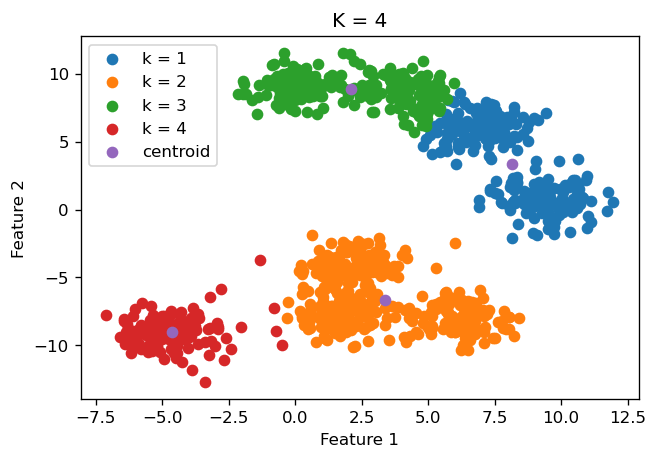

In [13]:
# plot data
plt.figure(dpi=120)
for k in range(K):
    x1 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_0']
    x2 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_1']
    plt.scatter(x1, x2, label="k = "+str(k+1))
    
# show cluster centroid locations
plt.scatter(centers[:,0],centers[:,1],label="centroid")


plt.legend()
plt.title("K = 4")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

Although K-means tried, this configuration is a far cry from the initial clusters we generated in Figure 1. A useful observation here is that cluster centroids can also occur in places where there is no data. 

Anyway, let's see if we can pick a better K.  

## Deciding on the number of Clusters (K)
We can now revisit the topic of having to specify a number of clusters K when using the K-means method. 

### 1. Within cluster variation 
We will make use of a popular technique called the **'Elbow Method'** to determine how many clusters to choose. 

To use the elbow method, we will perform K-means clustering a number of times, changing the value of k each time. For each value of k, we will measure the **total within-cluster sum of squares**, or **WCSS**. Put simply, the WCSS is computed by calculating the sum of squared distances between cluster centroids and the data points that belong to them. These *within-cluster sum of squares* are then added together to obtain the *total within-cluster sum of squares* or *WCSS*:

 $$ \Large
\text{WCSS} = \sum \limits_{i=1}^{K} \sum \limits_{j = 1}^{|P_i|} \text{distance}(P_{ij},C_i)^{2}
$$

WCSS is a measure of the similarity of the observations within our clusters. Lower WCSS means that a cluster is more tightly grouped. Naturally, as we increase k, WCSS will decrease until k is equal to the number of data points in our data set (when WCSS will be zero). But what use is it to have as many clusters as there are observations? We need to find the optimal number of clusters so that each cluster is sufficiently consistent in its attributes without having too many clusters.   

<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/sketch-wcss.png?raw=true" alt="Types of Clustering" style="width: 80%;"/>

Take a look at the loop below.

We have chosen a range of values for k between 1 and 20. For each value of k, we will run the k-means clustering algorithm and record the WCSS (referred to as **`inertia_`** in sklearn. However, for reasons that will become obvious later, we will implement our own WCSS here).

_Have a look at the docstring of the **`KMeans`** function (using `help()`)to find out what the **`n_init`** and **`max_iter`** arguments do._

In [14]:
# Manually implement the WCSS
def within_cluster_variation(df, label_col='label'):
    centroids = df.groupby(label_col).mean()
    out = 0
    for label, point in centroids.iterrows():
        df_features = df[df[label_col] == label].drop(label_col, axis=1)
        out += (df_features - point).pow(2).sum(axis=1).sum()
    return out

In [15]:
# let's try everything between 2 and 20 clusters
n_clusters = np.arange(2, 21)

# store errors for each value of k
errors = []

# for i between 2 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X_scaled)
    
    # measure BCSS

    y_preds = km.predict(X_scaled)
    df_no_labels['cluster_label'] = y_preds
    errors.append(within_cluster_variation(df_no_labels,'cluster_label'))

Now that we have performed k-means clustering for each value of k between 2 and 20, we need to create a plot showing the WCSS for each corresponding value of k.

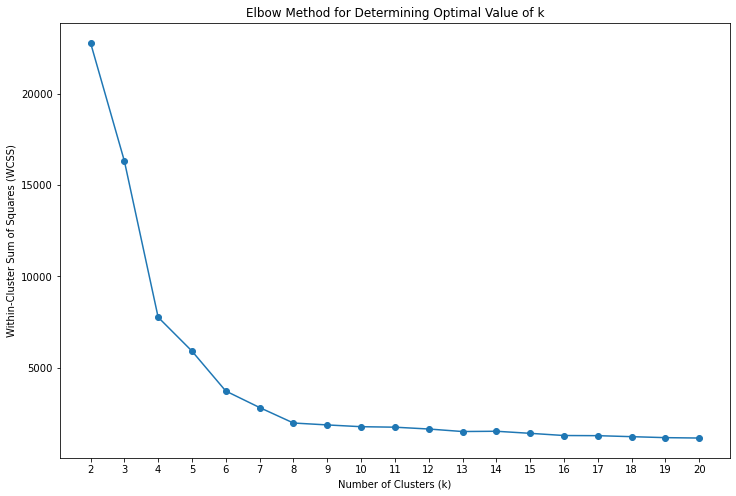

In [16]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

Using the elbow method is as simple as observing the plot of the within-cluster sum of squares (WCSS) for each number of clusters and deciding where the 'elbow' is. The elbow is loosely defined as the point at which the WCSS curve has its greatest decrease in slope. In other words, it is the point after which adding another cluster does not meaningfully decrease the WCSS.

Below, we have provided a copy of the code used to generate the elbow plot from above. The 2nd last line of code is incomplete - set the `x=` argument in the `plt.axvline()` function to draw a vertical line at the number of clusters you think the elbow occurs at.

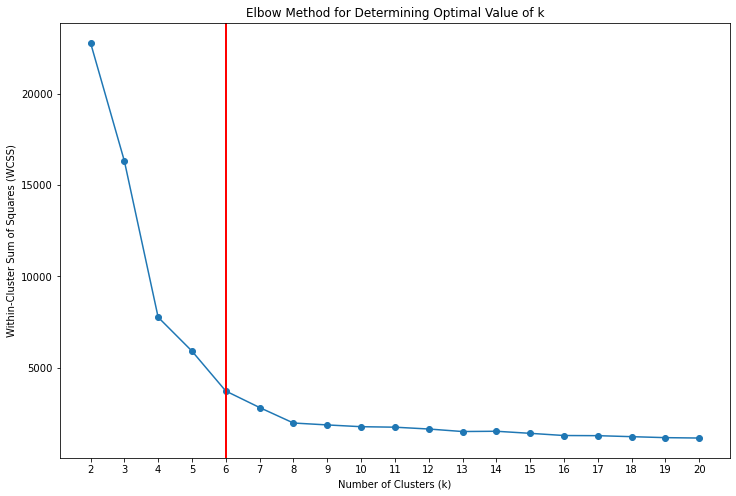

In [18]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)

# SET THE X-VALUE BELOW TO THE NUMBER OF CLUSTERS
# AT WHICH THE ELBOW OCCURS, e.g. plt.axvline(x=18, color='r', lw=2)
plt.axvline(x=6, color='r', lw=2)
plt.show()

# run this code block by hitting Shift+Enter

Elbow plots are tricky to decipher, **particularly because this graph keeps on decreasing**. However, we can see a clear kink at k=6 - this is where you should have plotted your vertical line. We will now cluster our observations using k=6.

In [19]:
K = 6
# remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_scaled)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(n_clusters=6, random_state=42)
done in 0.009s


In [20]:
# obtain cluster memberships for each item in the data
y_preds = km.predict(X_scaled)
df_no_labels['cluster_label'] = y_preds
centers = scaler.inverse_transform(km.cluster_centers_)

Text(0, 0.5, 'Feature 2')

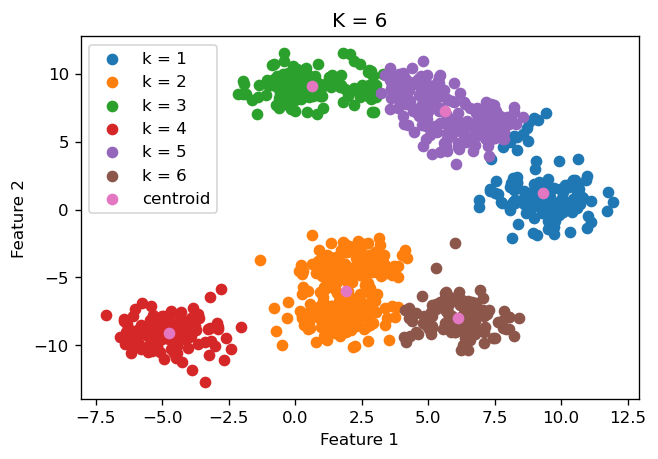

In [21]:
# visualise the clusters
plt.figure(dpi=120)
for k in range(K):
    x1 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_0']
    x2 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_1']
    plt.scatter(x1, x2, label="k = "+str(k+1))
    
# show cluster centroid locations
plt.scatter(centers[:,0],centers[:,1],label="centroid")


plt.legend()
plt.title("K = 6")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

So it looks like $K=6$ did much better than $K=4$. Let's see if other methods for selecting $K$ can do better. 

### 2. Between-cluster variation

If the WCSS measures the variation **within each cluster** (i.e., how spread apart the data in a cluster is from the centroid), between cluster variation measures how spread apart the clusters are from each other:

 $$ \Large
\text{BCSS} =  \sum \limits_{k = 1}^{K} n_{k}(C_k - \bar{X})^{2}
$$

Where:
- $n_{k}$ is the number of data points in the $k^{th}$ cluster
- $C_k$ is the centroid of the $k^{th}$ cluster
- $\bar{X}$ is the mean of all data points, i.e. $\bar{X} = \frac{1}{n} \sum \limits_{i=1}^{n}X_i$

Let's implement this and compare it with the WCSS method:

In [22]:
# Between cluster variation
def between_cluster_variation(df, label_col='label'):
    centroids = df.groupby(label_col).mean()
    global_mean = df.drop(label_col, axis=1).mean()
    centroid_count = df.groupby(label_col).size()
    centroid_to_mean_dist = (centroids - global_mean).pow(2).sum(axis=1)
    return (centroid_count*centroid_to_mean_dist).sum()

In [23]:
# let's try everything between 2 and 20 clusters
n_clusters = np.arange(2, 21)

# store errors for each value of k
errors = []

# for i between 2 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X_scaled)
    
    # measure BCSS

    y_preds = km.predict(X_scaled)
    df_no_labels['cluster_label'] = y_preds
    errors.append(between_cluster_variation(df_no_labels,'cluster_label'))

Now that we have performed k-means clustering for each value of k between 4 and 20, we need to create a plot showing the BCSS for each corresponding value of k. Since we are measuring how spread out the clusters are, we prefer our BCSS to be higher for clusters that are further apart and lower for those that are close. 

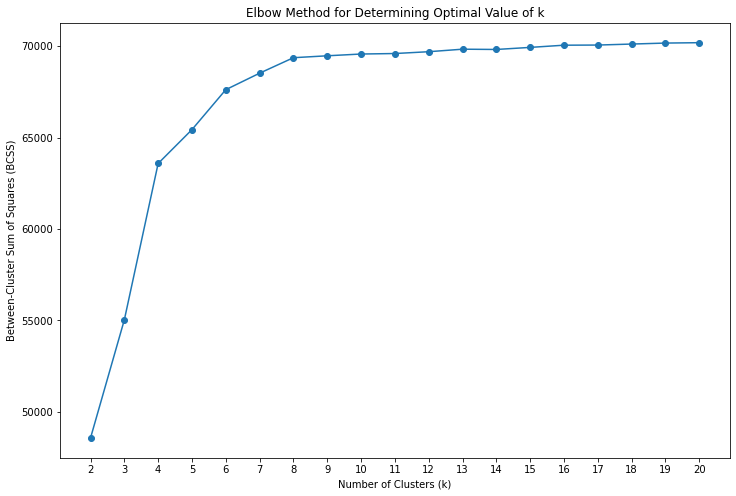

In [24]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Between-Cluster Sum of Squares (BCSS)')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

Picking the optimal number of clusters here is still the same as with WCSS; the only difference is that our elbow is now upside-down. Like before, we see a clear kink at $K=6$.   

However, this method also has an issue where the BCSS keeps increasing. What we would like is something that stops increasing/decreasing after we have found the right number of clusters. 

Since we have already seen what the clusters look like with $K=4$, let's jump straight into the next method.

### 3. The CH index

Again, the ideal scenario is where our clustering assignments have a small WCSS and a large BCSS simultaneously. The CH index combines these two metrics in a clever way so that it's easy to isolate areas where the WCSS is small and the BCSS is large. For a given value of $K$, the CH index can be computed as follows: 

 $$ \Large
\text{CH(K)} =  \frac{BCSS(K)/(K-1)}{WCSS(K)/(n-1)}
$$

Notice that this involves computing both the BCSS and the WCSS. Using the functions we've defined above, the CH index can be implemented as follows:


In [25]:
def ch_index(df, label_col='label'):
    n = len(df)
    K = df[label_col].nunique()
    B = between_cluster_variation(df, label_col)
    W = within_cluster_variation(df, label_col)
    return (B / (K-1)) / (W / (n-K))

In [26]:
# let's try everything between 1 and 20 clusters
n_clusters = np.arange(2, 21)

# store errors for each value of k
errors = []

# for i between 1 and 20
for k in n_clusters:
    # perform k-means clustering
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    km.fit(X_scaled)
    
    # measure CH

    y_preds = km.predict(X_scaled)
    df_no_labels['cluster_label'] = y_preds
    errors.append(ch_index(df_no_labels,'cluster_label'))

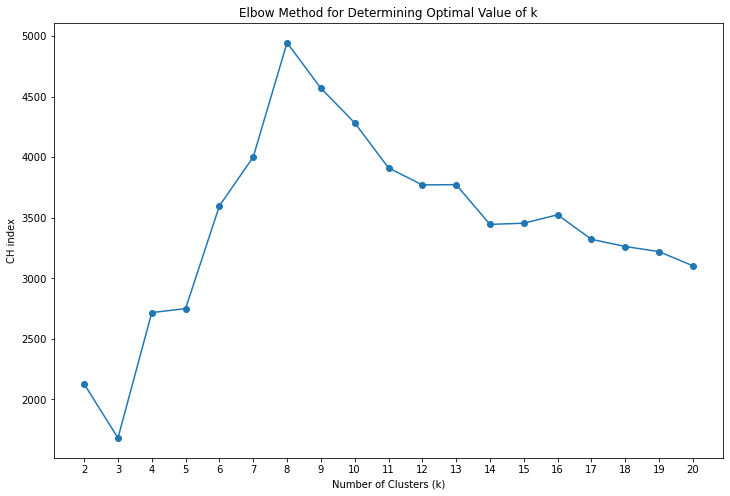

In [27]:
plt.figure(figsize=(12,8))
plt.xlabel('Number of Clusters (k)')
plt.ylabel('CH index')
plt.title('Elbow Method for Determining Optimal Value of k')
plt.scatter(n_clusters, errors)
plt.plot(n_clusters, errors)
plt.xticks(n_clusters)
plt.show()

Here, we see a very obvious peak at $K=8$ (if you still remember, this is what we used to generate the data, but the algorithm didn't know this). This metric is definitely easier to interpret. The rule of thumb here is to investigate each peak. These include $K=4$, $K=8$, $K=13$, $K=16$, and $K=19$ in cases where things aren't clear. In this case, however, it is super clear that the obvious number of clusters is $K=8$! 

Let's try it out and see how it does:

In [28]:
K = 8
# remember to set the random state for reproducibility
km = KMeans(n_clusters=K, verbose=0, random_state=42)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_scaled)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with KMeans(random_state=42)
done in 0.011s


In [29]:
# obtain cluster memberships for each item in the data
y_preds = km.predict(X_scaled)
df_no_labels['cluster_label'] = y_preds
centers = scaler.inverse_transform(km.cluster_centers_)

Text(0, 0.5, 'Feature 2')

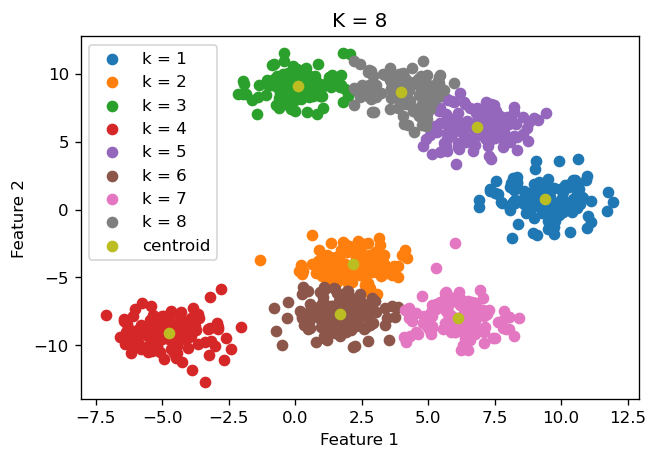

In [30]:
# visualise the clusters
plt.figure(dpi=120)
for k in range(K):
    x1 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_0']
    x2 = df_no_labels[df_no_labels['cluster_label'] == k]['feature_1']
    plt.scatter(x1, x2, label="k = "+str(k+1))
    
# show cluster centroid locations
plt.scatter(centers[:,0],centers[:,1],label="centroid")


plt.legend()
plt.title("K = 8")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

This looks great! but for good measure, let's compare with the original dataset we generated:

Text(0, 0.5, 'Feature 2')

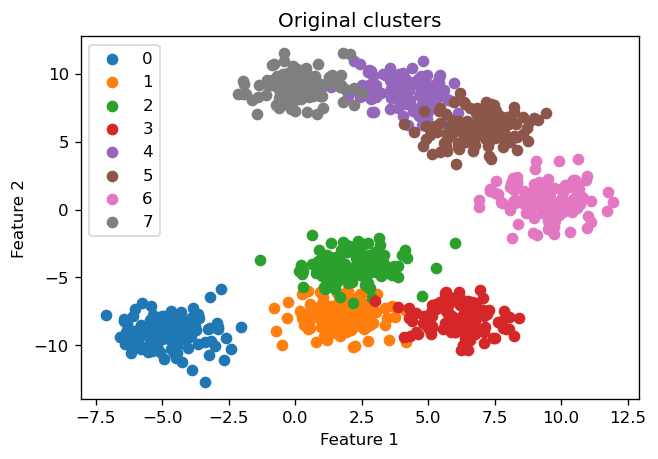

In [31]:
# plot data
plt.figure(dpi=120)
for center in range(8):
    x1 = df[df['y'] == center]['feature_0']
    x2 = df[df['y'] == center]['feature_1']
    plt.scatter(x1, x2, label=str(center))

plt.legend()
plt.title("Original clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

We seem to have captured most of the clusters. However, K-means could not correctly assign data points in regions where the clusters overlap. This is a characteristic of all **hard clustering algorithms**.

## Evaluation metrics

Clustering algorithms like K-means produce clusters, but how do we know if these clusters are of good quality?
We can use evaluation metrics to **assess the quality** of our clusters. Two common metrics are the `silhouette score` and the `Davies-Bouldin index`.

### Silhouette Score
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
It ranges from -1 to 1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighbouring clusters.
A silhouette score close to 1 suggests that the object is appropriately assigned to its cluster, while a score near -1 indicates that it is assigned to the wrong cluster.
In clustering, we aim for a high silhouette score, as it indicates well-separated clusters and a clear distinction between them.
The silhouette score is computed for each sample and then averaged to obtain an overall score for the clustering.

Let's calculate the Silhouette score for our clusters.

In [32]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_scaled, km.labels_)
print("\nSilhouette Score:", silhouette_avg)


Silhouette Score: 0.5756529827045825


The silhouette score of 0.576 indicates a reasonably good clustering result. It suggests that the clusters are fairly distinct and well-defined, with minimal overlap between them. Overall, it indicates a relatively successful partitioning of the data into meaningful clusters.

### Davies-Bouldin Index
The Davies-Bouldin index is another measure of cluster validity that evaluates the average similarity between each cluster and its most similar cluster.
It is defined as the ratio of the average intra-cluster distance to the distance between cluster centroids.
Lower values of the Davies-Bouldin index indicate better clustering, with tight and well-separated clusters.
A high Davies-Bouldin index suggests that clusters overlap or are poorly separated.
Like the silhouette score, the Davies-Bouldin index is used to assess the quality of clustering solutions and guide the selection of the optimal number of clusters.

Let's calculate the Davies-Bouldin index for our clusters.

In [34]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(X_scaled, km.labels_)
print("\nDavies-Bouldin Index:", db_index)


Davies-Bouldin Index: 0.5980496802852364


The Davies-Bouldin index of 0.598 indicates a relatively good clustering result. It suggests that the clusters are reasonably well-separated, with each cluster having distinct characteristics compared to the others. While not as intuitive as the silhouette score, a lower Davies-Bouldin index still signifies a good clustering outcome, indicating that the clusters are cohesive and well-defined. Therefore, in this context, a Davies-Bouldin index of 0.598 reflects a satisfactory partitioning of the data into meaningful clusters.

The silhouette score and Davies-Bouldin index corroborate our assessment of the clustering visualisation. While K-means successfully identified the majority of clusters, it struggled with accurate assignments for some data points. Overall, K-means demonstrates moderate effectiveness as a clustering method for our dataset. However, exploring alternative clustering methods might offer improvements in clustering accuracy and overall performance.

### Advantages and disadvantages of k-means clustering 

**Advantages**
- Computationally efficient clustering technique 
- Suitable for large datasets 
- Easy to implement and interpret 
- Easily adaptable to new datasets

**Disadvantages**
- Lacks consistency 
- Sensitive to scaling 
- Dependent on initial values 

## Conclusion

You have now learned what clustering means, what the different types of clustering are, how to cluster a given dataset using the k-means algorithm, how to use various methods for determining the optimal number of clusters K, and finally, how to do a basic analysis of the resulting clusters.

## Appendix 
A link to an additional resource to help with the understanding of the concepts presented in this train. 

> - [How to choose the number of clusters K?](http://www2.stat.duke.edu/~rcs46/lectures_2017/10-unsupervise/10-specify-clusters.pdf)

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>